In [107]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
import sklearn.metrics as metrics
from tqdm import tqdm

In [108]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [109]:
ptv_result = [0] * 3

In [110]:
with open(f'ptv_cbi_q_10.pickle', mode='rb') as fp:
    ptv_result[0] = pickle.load(fp)
with open(f'ptv_cbi_q_20.pickle', mode='rb') as fp:
    ptv_result[1] = pickle.load(fp)
with open(f'ptv_cbi_q_30_high.pickle', mode='rb') as fp:
    ptv_result[2] = pickle.load(fp)

In [111]:
for i in range(3):
    ptv_result[i]['r'] = np.sqrt(ptv_result[i]['x']**2 + ptv_result[i]['y']**2)

In [112]:
px2mm = 1000 / np.sqrt((498 - 488)**2 + (391 - 646)**2)/1e3
fps = 25

In [113]:
ptv_result[0]['r'].max()*px2mm

1.9738469844976998

In [114]:
res_sort = [0] * 3

for i in range(3):
    res_sort[i] = ptv_result[i].sort_values(by='r', ascending=True).values

In [115]:
_iter = 50
res = [0]*3
res2 = [0]*3

In [116]:
for c in range(3):
    r_dr_err = np.zeros((5001, 3))
    r_dr_in = np.zeros((1, 2))
    r_dr_err[:, :] = np.nan
    r_dr_in[:, :] = np.nan

    for i in tqdm(range(0, 5001, _iter)):
        res_sort_l = res_sort[c][np.where(res_sort[c][:, 4] >= i/10)]
        res_sort_lr = res_sort_l[np.where(res_sort_l[:, 4] < (i+_iter)/10)]
        columns = ['x', 'y', 'dx', 'dy', 'r', 'theta', 'dr']
        df = pd.DataFrame(data=res_sort_lr, columns=columns, dtype='float')
        q1 = df['dr'].quantile(0.25)
        q2 = df['dr'].quantile(0.75)
        iqr = q2 - q1

        upper = q2 + 1.5 * iqr
        bottom = q1 - 1.5 * iqr
        _in = df[(df['dr'] >= bottom) & (df['dr'] <= upper)].values
        tmp = np.array([_in[:, 4], _in[:, 6]]).T
        r_dr_in = np.vstack([r_dr_in, tmp])

        r_dr_err[i, 0] = i
        r_dr_err[i, 1] = np.mean(tmp, axis=0)[1]
        r_dr_err[i, 2] = np.std(tmp, axis=0)[1]

    r_dr_err = r_dr_err[::_iter]
    res[c] = r_dr_err
    res2[c] = r_dr_in

100%|██████████| 101/101 [00:01<00:00, 81.85it/s]


In [117]:
def fit_func(params, x, y):
    return y - (params[0] / x)

def fit_func2(params, x, y):
    return y - (params[0] / x**2)

def fit_exp(params, x, y):
    return y - (params[0] * np.exp(params[1] * x))

def func(params, x):
    return params[0] / x

def func_2(params, x):
    return params[0] / x**2

def func_exp(params, x):
    return params[0] * np.exp(params[1] * x)

In [118]:
r = np.linspace(500, 1500, 1000)/1e3

0.4611632351533876 -1.547141621892669 0.9959571810072629
0.6435914139761832 -1.6478683559414669 0.9874344845041181
0.6456916734194241 -1.5161090839636324 0.9736891998041745


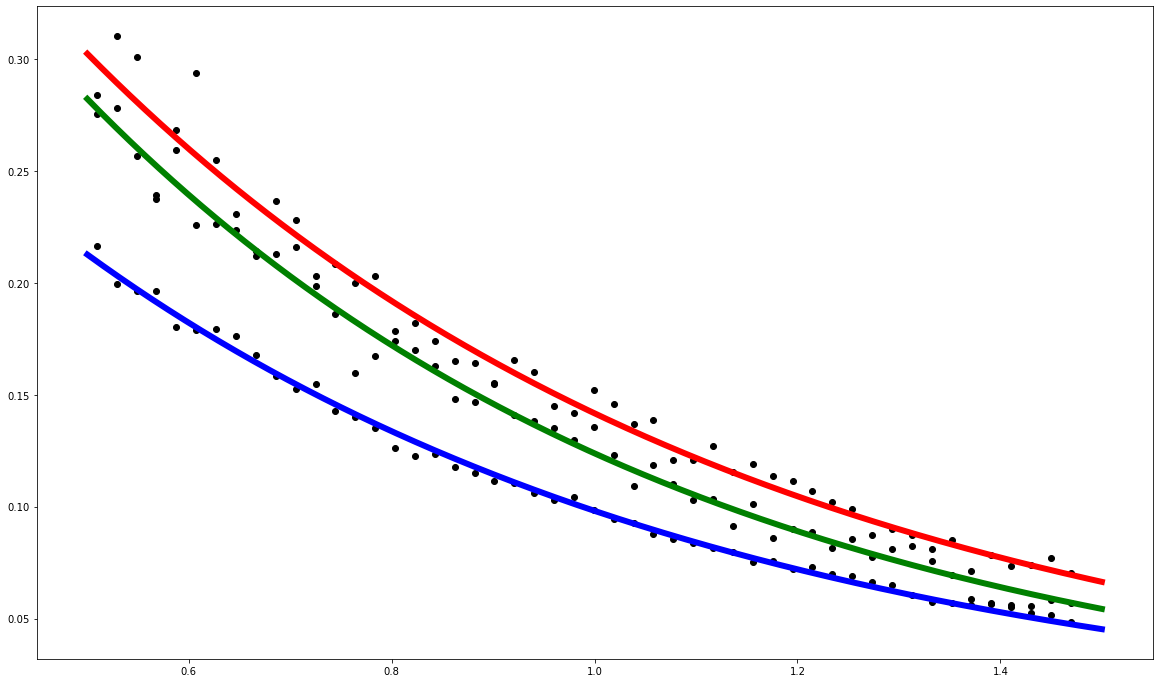

In [119]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(res[0][26:-25, 0]*px2mm/10, res[0][26:-25, 1]*px2mm*fps, c='k')
ax.scatter(res[1][26:-25, 0]*px2mm/10, res[1][26:-25, 1]*px2mm*fps, c='k')
ax.scatter(res[2][26:-25, 0]*px2mm/10, res[2][26:-25, 1]*px2mm*fps, c='k')

result_exp = optimize.leastsq(fit_exp, np.array([9., 0.]), args=(res[0][26:-25, 0]*px2mm/10, res[0][26:-25, 1]*px2mm*fps))
result_exp2 = optimize.leastsq(fit_exp, np.array([9., 0.]), args=(res[1][26:-25, 0]*px2mm/10, res[1][26:-25, 1]*px2mm*fps))
result_exp3 = optimize.leastsq(fit_exp, np.array([9., 0.]), args=(res[2][26:-25, 0]*px2mm/10, res[2][26:-25, 1]*px2mm*fps))

r2_exp = metrics.r2_score(res[0][26:-25, 1]*px2mm*fps, func_exp(result_exp[0], res[0][26:-25, 0]*px2mm/10))
r2_exp2 = metrics.r2_score(res[1][26:-25, 1]*px2mm*fps, func_exp(result_exp2[0], res[1][26:-25, 0]*px2mm/10))
r2_exp3 = metrics.r2_score(res[2][26:-25, 1]*px2mm*fps, func_exp(result_exp3[0], res[2][26:-25, 0]*px2mm/10))

print(result_exp[0][0], result_exp[0][1], r2_exp)
print(result_exp2[0][0], result_exp2[0][1], r2_exp2)
print(result_exp3[0][0], result_exp3[0][1], r2_exp3)

ax.plot(r, result_exp[0][0] * np.exp(result_exp[0][1] * r), linewidth=6, c='b')
ax.plot(r, result_exp2[0][0] * np.exp(result_exp2[0][1] * r), linewidth=6, c='g')
ax.plot(r, result_exp3[0][0] * np.exp(result_exp3[0][1] * r), linewidth=6, c='r')

plt.show()

In [126]:
r = np.linspace(400, 800, 1000)/1e3

0.10925397047910256 0.9880959208596616
0.14320454210070993 0.9278924763105934
0.15212524807529268 0.8773361930275569


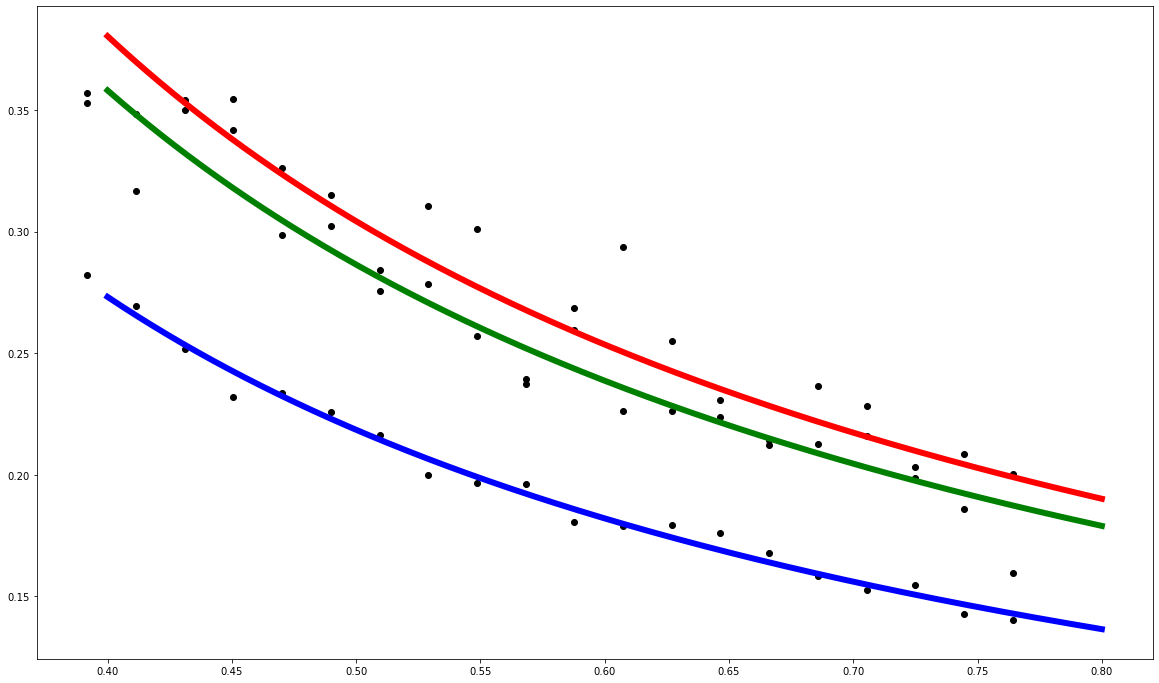

In [129]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(res[0][20:40, 0]*px2mm/10, res[0][20:40, 1]*px2mm*fps, c='k')
ax.scatter(res[1][20:40, 0]*px2mm/10, res[1][20:40, 1]*px2mm*fps, c='k')
ax.scatter(res[2][20:40, 0]*px2mm/10, res[2][20:40, 1]*px2mm*fps, c='k')

result_p = optimize.leastsq(fit_func, np.array([9.]), args=(res[0][20:40, 0]*px2mm/10, res[0][20:40, 1]*px2mm*fps))
result_p2 = optimize.leastsq(fit_func, np.array([9.]), args=(res[1][20:40, 0]*px2mm/10, res[1][20:40, 1]*px2mm*fps))
result_p3 = optimize.leastsq(fit_func, np.array([9.]), args=(res[2][20:40, 0]*px2mm/10, res[2][20:40, 1]*px2mm*fps))

r2_p = metrics.r2_score(res[0][20:40, 1]*px2mm*fps, func(result_p[0], res[0][20:40, 0]*px2mm/10))
r2_p2 = metrics.r2_score(res[1][20:40, 1]*px2mm*fps, func(result_p2[0], res[1][20:40, 0]*px2mm/10))
r2_p3 = metrics.r2_score(res[2][20:40, 1]*px2mm*fps, func(result_p3[0], res[2][20:40, 0]*px2mm/10))

print(result_p[0][0], r2_p)
print(result_p2[0][0], r2_p2)
print(result_p3[0][0], r2_p3)

ax.plot(r, result_p[0][0] / r, linewidth=6, c='b')
ax.plot(r, result_p2[0][0]/ r, linewidth=6, c='g')
ax.plot(r, result_p3[0][0]/ r, linewidth=6, c='r')

plt.show()

In [130]:
r = np.linspace(1200, 1500, 1000)/1e3

0.10695671104046198 0.9648529963474703
0.12652597975573926 0.7606521663864678
0.15023247025266528 0.8700198327902743


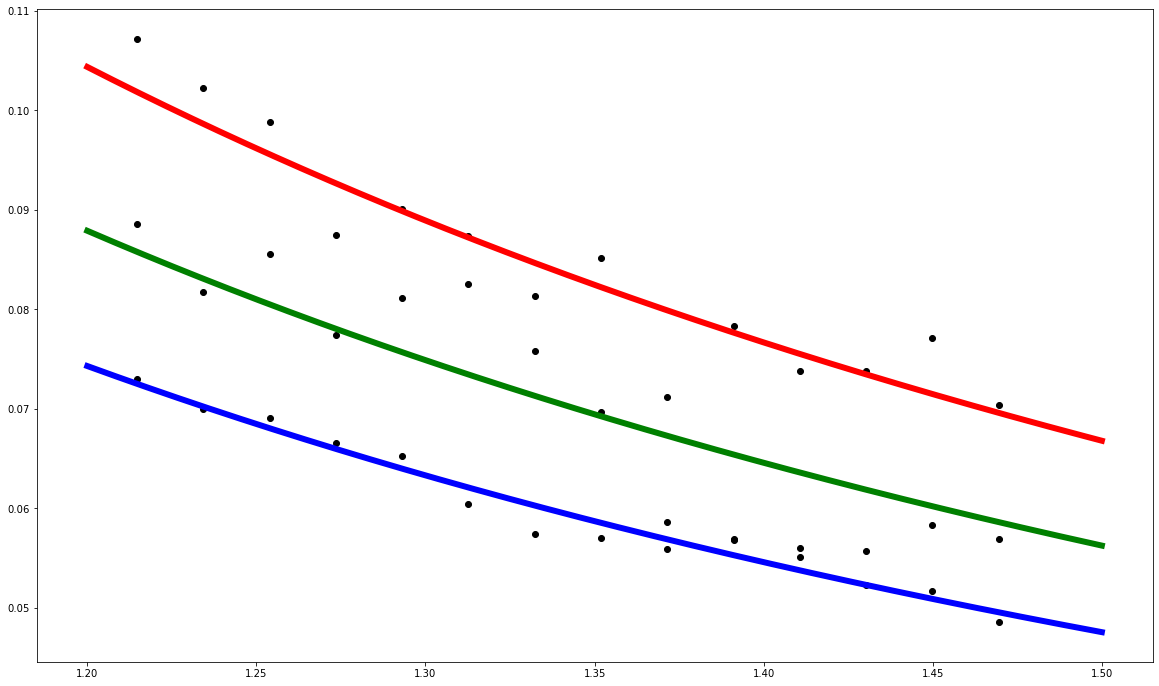

In [133]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(res[0][62:-25, 0]*px2mm/10, res[0][62:-25, 1]*px2mm*fps, c='k')
ax.scatter(res[1][62:-25, 0]*px2mm/10, res[1][62:-25, 1]*px2mm*fps, c='k')
ax.scatter(res[2][62:-25, 0]*px2mm/10, res[2][62:-25, 1]*px2mm*fps, c='k')

result_p = optimize.leastsq(fit_func2, np.array([9.]), args=(res[0][62:-25, 0]*px2mm/10, res[0][62:-25, 1]*px2mm*fps))
result_p2 = optimize.leastsq(fit_func2, np.array([9.]), args=(res[1][62:-25, 0]*px2mm/10, res[1][62:-25, 1]*px2mm*fps))
result_p3 = optimize.leastsq(fit_func2, np.array([9.]), args=(res[2][62:-25, 0]*px2mm/10, res[2][62:-25, 1]*px2mm*fps))

r2_p = metrics.r2_score(res[0][62:-25, 1]*px2mm*fps, func_2(result_p[0], res[0][62:-25, 0]*px2mm/10))
r2_p2 = metrics.r2_score(res[1][62:-25, 1]*px2mm*fps, func_2(result_p2[0], res[1][62:-25, 0]*px2mm/10))
r2_p3 = metrics.r2_score(res[2][62:-25, 1]*px2mm*fps, func_2(result_p3[0], res[2][62:-25, 0]*px2mm/10))

print(result_p[0][0], r2_p)
print(result_p2[0][0], r2_p2)
print(result_p3[0][0], r2_p3)

ax.plot(r, result_p[0][0] / r**2, linewidth=6, c='b')
ax.plot(r, result_p2[0][0]/ r**2, linewidth=6, c='g')
ax.plot(r, result_p3[0][0]/ r**2, linewidth=6, c='r')

plt.show()

In [ ]:
def fit_for_q(params, x, y):
    return y - (np.power(x, 0.33) * params[0] + params[1])

def func_for_q(params, x):
    return np.power(x, 0.33) * params[0] + params[1]

In [ ]:
q = [17, 33, 50]
A = [0.4611632351533876, 0.6435914139761832, 0.6456916734194241]
B = [-1.547141621892669, -1.6478683559414669, -1.5161090839636324]

qq = np.linspace(0, 100, 1000)
aa = optimize.leastsq(fit_for_q, np.array([0., 0.]), args=(q, A))

In [139]:
C = [0.10925397047910256, 0.14320454210070993, 0.15212524807529268]
D = [0.10695671104046198, 0.12652597975573926, 0.15023247025266528]

cc = optimize.leastsq(fit_for_q, np.array([0., 0.]), args=(q, C))

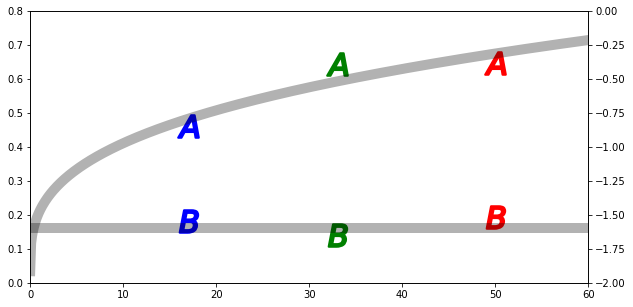

In [136]:
fig, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.twinx()

plt.xlim(0, 60)

ax.set_ylim(0, 0.8)
ax2.set_ylim(-2, 0)

ax.scatter(q[0], A[0], c='b', marker="$A$", s=500, linewidths=2.2)
ax2.scatter(q[0], B[0], c='b', marker="$B$", s=500, linewidths=2.2)

ax.scatter(q[1], A[1], c='g', marker="$A$", s=500, linewidths=2.2)
ax2.scatter(q[1], B[1], c='g', marker="$B$", s=500, linewidths=2.2)

ax.scatter(q[2], A[2], c='r', marker="$A$", s=500, linewidths=2.2)
ax2.scatter(q[2], B[2], c='r', marker="$B$", s=500, linewidths=2.2)

ax.plot(qq, aa[0][0] * np.power(qq, 0.33) + aa[0][1], color='k', linewidth=10, alpha=0.3)
ax2.hlines(-1.6, 0, 60, color='k', linewidth=10, alpha=0.3)

plt.show()
# fig.savefig("exp.png")

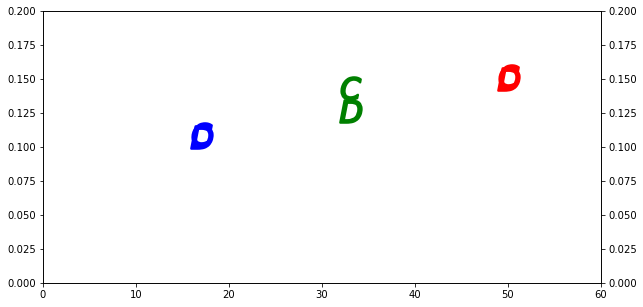

In [142]:
fig, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.twinx()

plt.xlim(0, 60)

ax.set_ylim(0, 0.2)
ax2.set_ylim(0, 0.2)

ax.scatter(q[0], C[0], c='b', marker="$C$", s=500, linewidths=2.2)
ax2.scatter(q[0], D[0], c='b', marker="$D$", s=500, linewidths=2.2)

ax.scatter(q[1], C[1], c='g', marker="$C$", s=500, linewidths=2.2)
ax2.scatter(q[1], D[1], c='g', marker="$D$", s=500, linewidths=2.2)

ax.scatter(q[2], C[2], c='r', marker="$C$", s=500, linewidths=2.2)
ax2.scatter(q[2], D[2], c='r', marker="$D$", s=500, linewidths=2.2)

# ax.plot(qq, cc[0][0] * np.power(qq, 0.33) + cc[0][1], color='k', linewidth=10, alpha=0.3)
# ax2.hlines(-1.6, 0, 60, color='k', linewidth=10, alpha=0.3)

plt.show()
fig.savefig("r1_r2.png")